In [45]:
import math
import io
import warnings
import fresnel
import IPython
import numpy
import packaging.version
import PIL
import freud
import gsd.hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [46]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot, particles=None, is_solid=None):

    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]

    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [47]:
traj = gsd.hoomd.open('trajectory.gsd')
len(traj)

5

In [48]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

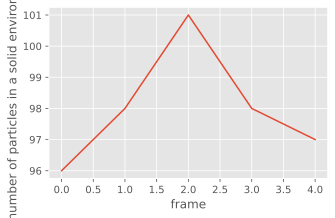

In [49]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

In [50]:
render_movie(traj[0:100:12])

UnboundLocalError: local variable 'im' referenced before assignment

In [44]:
start_frame = int(numpy.argmax(num_solid > 4))
end_frame = int(numpy.argmax(num_solid == numpy.max(num_solid)))
step = int((end_frame - start_frame) / 6)
print(f"Start Frame: {start_frame}, End Frame: {end_frame}")
render_movie(
    traj[start_frame:end_frame:step], is_solid=is_solid[start_frame:end_frame:step]
)

Start Frame: 0, End Frame: 2


ValueError: slice step cannot be zero